In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%connect_info

{
  "shell_port": 50724,
  "iopub_port": 50725,
  "stdin_port": 50726,
  "control_port": 50728,
  "hb_port": 50727,
  "ip": "127.0.0.1",
  "key": "7a360c03-70af00612bec5965e049f7c8",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": "python3",
  "jupyter_session": "/Users/bening/Code/_data_portfolios/titanic-challenge/notebooks/reexploration.ipynb"
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-33371650-6f12-4a16-9c6c-692dd026cd40.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.


# Titanic Survival Prediction

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from src.utils import skim_data, create_submission

ModuleNotFoundError: No module named 'src'

In [8]:
df_train = pd.read_csv('input/train.csv')
df_test = pd.read_csv('input/test.csv')

In [4]:
def check_missing(df):
    return (df.isna().sum() / df.shape[0])

In [5]:
check_missing(df_train)

PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64

In [6]:
check_missing(df_test)

PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64

In [7]:
X = df_train.drop(columns=['Survived'])
y = df_train['Survived']

In [8]:
# split train and test data

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=23,
                                                    stratify=y)

In [9]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
541,542,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.2750,NaN,S
306,307,1,"Fleming, Miss. Margaret",female,NaN,0,0,17421,110.8833,NaN,C
454,455,3,"Peduzzi, Mr. Joseph",male,NaN,0,0,A/5 2817,8.0500,NaN,S
199,200,2,"Yrois, Miss. Henriette (""Mrs Harbeck"")",female,24.0,0,0,248747,13.0000,NaN,S
397,398,2,"McKane, Mr. Peter David",male,46.0,0,0,28403,26.0000,NaN,S


Data needs to be thrown away:

- PassengerId
- Ticket

## Data Imputation

- Age (based on Pclass)
- Embarked
- Fare

### Age (based on Pclass)

In [45]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

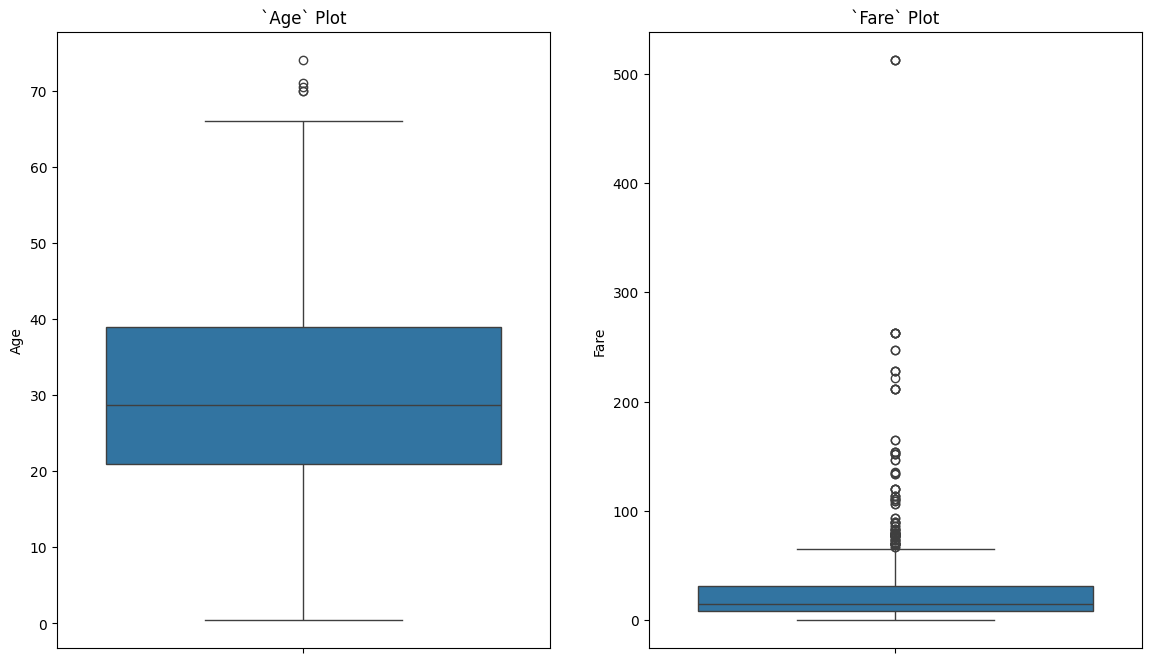

In [27]:
cols = ['Age', 'Fare']

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 8))

for idx, col in enumerate(cols):
    sns.boxplot(ax=axes[idx], data=X_train[col])
    axes[idx].set_title(f'`{col}` Plot')

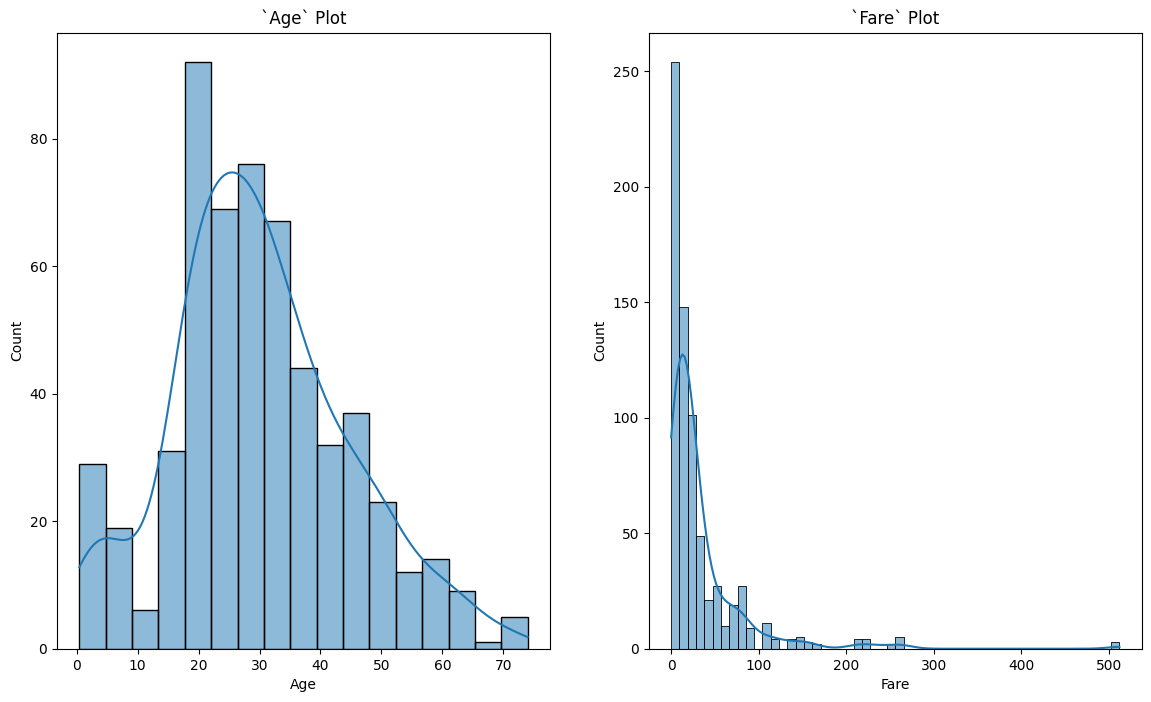

In [30]:
cols = ['Age', 'Fare']

fig, axes = plt.subplots(ncols=len(cols), figsize=(14, 8))

for idx, col in enumerate(cols):
    sns.histplot(ax=axes[idx], data=X_train[col], kde=True)
    axes[idx].set_title(f'`{col}` Plot')

In [60]:
def winsorizer(data: pd.DataFrame):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return lower_bound, upper_bound

In [122]:
class AgeImputer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.median_ages_ = X.groupby('Pclass')['Age'].median()
        self.overall_median_age_ = X['Age'].median()
        return self

    def transform(self, X):
        X_transform = X.copy()
        for pclass, median_age in self.median_ages_.items():
            X_transform.loc[(X_transform['Pclass'] == pclass) & (X_transform['Age'].isnull()), 'Age'] = median_age
        X_transform['Age'] = X_transform['Age'].fillna(self.overall_median_age_)
        return X_transform[['Age', 'Pclass']]

    def get_feature_names_out(self, input_features=None):
        return ['Age', 'Pclass']

class AgeWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.lower_, self.upper_ = winsorizer(X['Age'])
        return self

    def transform(self, X):
        X = X.copy()
        X['Age'] = X['Age'].clip(lower=self.lower_, upper=self.upper_)
        return X[['Age', 'Pclass']]

    def get_feature_names_out(self, input_features=None):
        return ['Age', 'Pclass']

In [68]:
age_imputer = ('age_imputer', AgeImputer())
age_winsorizer = ('age_winsorizer', AgeWinsorizer())
age_pipeline = Pipeline(steps=[age_imputer, age_winsorizer])

age_prep = ColumnTransformer(
    transformers=[
        ('age_pipeline', age_pipeline, ['Age', 'Pclass']),
    ],
    remainder='drop'
)
age_prep.set_output(transform='pandas')

temp_age = age_prep.fit_transform(X_train)

temp_age.info()
temp_age.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 712 entries, 541 to 673
Data columns (total 2 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age_pipeline__Age     712 non-null    float64
 1   age_pipeline__Pclass  712 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 16.7 KB


,age_pipeline__Age,age_pipeline__Pclass
count,712.000000,712.00000
mean,29.059691,2.29073
std,12.420597,0.84429
min,2.750000,1.00000
25%,23.000000,1.00000
50%,26.000000,3.00000
75%,36.500000,3.00000
max,56.750000,3.00000


### Embarked

<Axes: xlabel='count', ylabel='Embarked'>

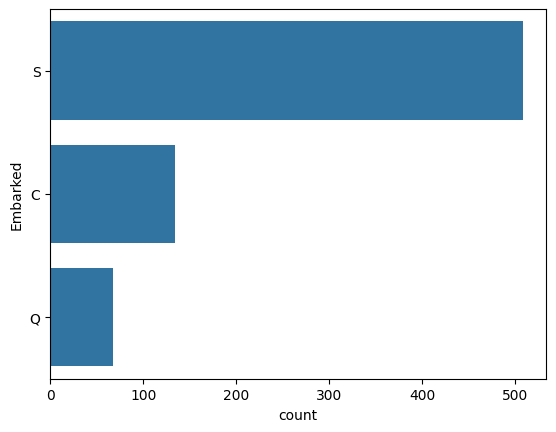

In [53]:
sns.countplot(data=X_train['Embarked'])

<Axes: xlabel='Embarked', ylabel='count'>

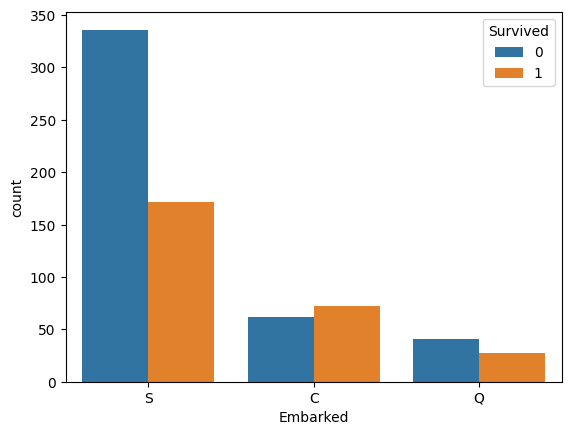

In [56]:
sns.countplot(data=pd.concat([X_train, y_train], axis=1), x='Embarked', hue='Survived', order=['S', 'C', 'Q'])

In [52]:
embark_imputer = SimpleImputer(strategy='most_frequent')
embark_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
embark_pipeline = Pipeline(
    steps=[
        ('embark_imputer', embark_imputer),
        ('embark_ohe', embark_ohe)
    ]
)

embark_prep = ColumnTransformer(
    transformers=[('embark_pipeline', embark_pipeline, ['Embarked'])],
    remainder='drop'
)
embark_prep.set_output(transform='pandas')

temp_embark = embark_prep.fit_transform(X_train)

display(X_train['Embarked'])
display(temp_embark)
# X_train['Embarked'].info()
# temp_embark.info()
# temp_embark.describe()

541    S
306    C
454    S
199    S
397    S
      ..
51     S
590    S
41     S
23     S
673    S
Name: Embarked, Length: 712, dtype: object

,embark_pipeline__Embarked_C,embark_pipeline__Embarked_Q,embark_pipeline__Embarked_S
541,0.0,0.0,1.0
306,1.0,0.0,0.0
454,0.0,0.0,1.0
199,0.0,0.0,1.0
397,0.0,0.0,1.0
...,...,...,...
51,0.0,0.0,1.0
590,0.0,0.0,1.0
41,0.0,0.0,1.0
23,0.0,0.0,1.0


### Fare

In [58]:
X_train['Fare'].median()

np.float64(14.47915)

In [63]:
class FareWinsorizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        self.lower_, self.upper_ = winsorizer(X['Fare'])
        return self

    def transform(self, X):
        X = X.copy()
        X['Fare'] = X['Fare'].clip(lower=self.lower_, upper=self.upper_)
        return X[['Fare']]

    def get_feature_names_out(self, input_features=None):
        return ['Fare']

In [66]:
fare_imputer = ('fare_imputer', SimpleImputer(strategy='median'))
fare_winsorizer = ('fare_winsorizer', FareWinsorizer())
fare_pipeline = Pipeline(steps=[fare_imputer, fare_winsorizer])

fare_prep = ColumnTransformer(
    transformers=[('fare_pipeline', fare_pipeline, ['Fare'])],
    remainder='drop'
)
fare_prep.set_output(transform='pandas')

display(X_train['Fare'])
display(fare_prep.fit_transform(X_train))

541     31.2750
306    110.8833
454      8.0500
199     13.0000
397     26.0000
         ...   
51       7.8000
590      7.1250
41      21.0000
23      35.5000
673     13.0000
Name: Fare, Length: 712, dtype: float64

,fare_pipeline__Fare
541,31.27500
306,66.58125
454,8.05000
199,13.00000
397,26.00000
...,...
51,7.80000
590,7.12500
41,21.00000
23,35.50000


## Feature Engineering

- Title (taken from name)
- HasCabin (taken from Cabin)
- FamilySize (taken from SibSp and Parch)

### Title

In [77]:
class TitleTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, 
                 name_col='Name',
                 title_col='Title',
                 title_thres='Master'):
        self.name_col = name_col
        self.title_col = title_col
        self.title_thres = title_thres

    def _clean_title(self, title):
        if title in ['Ms', 'Mlle']: return 'Miss'
        if title in ['Mme']: return 'Mrs'
        return title

    def fit(self, X, y=None):
        X_fit = X.copy()
        titles = (
            X_fit[self.name_col]
            .str.extract(r' ([A-Za-z]+)\.', expand=False)
            .apply(self._clean_title)
        )
        counts = titles.value_counts()
        threshold = counts.get(self.title_thres, 0)
        self.rare_titles_ = counts[counts < threshold].index.tolist()
        return self

    def transform(self, X):
        X_transformed = X.copy()
        titles = (
            X_transformed[self.name_col]
            .str.extract(r' ([A-Za-z]+)\.', expand=False)
            .apply(self._clean_title)
        )
        X_transformed[self.title_col] = titles.replace(self.rare_titles_, 'Rare')
        return X_transformed[[self.title_col]]

    def get_feature_names_out(self, input_features=None):
        return [self.title_col]

In [80]:
title_transformer = ('title_transformer', TitleTransformer())
title_encoder = ('title_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
title_pipeline = Pipeline(
    steps=[title_transformer, title_encoder]
)
title_prep = ColumnTransformer(
    transformers=[('title_pipeline', title_pipeline, ['Name'])],
    remainder='drop'
)
title_prep.set_output(transform='pandas')

,transformers,"[('title_pipeline', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'
,name_col,'Name'
,title_col,'Title'
,title_thres,'Master'


In [81]:
title_prep.fit_transform(X_train)

,title_pipeline__Title_Master,title_pipeline__Title_Miss,title_pipeline__Title_Mr,title_pipeline__Title_Mrs,title_pipeline__Title_Rare
541,0.0,1.0,0.0,0.0,0.0
306,0.0,1.0,0.0,0.0,0.0
454,0.0,0.0,1.0,0.0,0.0
199,0.0,1.0,0.0,0.0,0.0
397,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...
51,0.0,0.0,1.0,0.0,0.0
590,0.0,0.0,1.0,0.0,0.0
41,0.0,0.0,0.0,1.0,0.0
23,0.0,0.0,1.0,0.0,0.0


### Cabin

In [88]:
class CabinTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X: pd.DataFrame, y=None):
        return self

    def transform(self, X):
        X_transform = X.copy()
        X_transform['HasCabin'] = X_transform['Cabin'].notna().astype('int')
        return X_transform[['HasCabin']]

    def get_feature_names_out(self, input_features=None):
        return ['HasCabin']

In [89]:
cabin_transformer = ('cabin_transformer', CabinTransformer(), ['Cabin'])
cabin_prep = ColumnTransformer(
    transformers=[cabin_transformer],
    remainder='drop'
)
cabin_prep.set_output(transform='pandas')

,transformers,"[('cabin_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'


In [90]:
cabin_prep.fit_transform(X_train)

,cabin_transformer__HasCabin
541,0
306,0
454,0
199,0
397,0
...,...
51,0
590,0
41,0
23,1


In [91]:
X_train['Cabin']

541    NaN
306    NaN
454    NaN
199    NaN
397    NaN
      ... 
51     NaN
590    NaN
41     NaN
23      A6
673    NaN
Name: Cabin, Length: 712, dtype: object

### FamilySize

In [93]:
class FamilySizeTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X_transform = X.copy()
        X_transform['FamilySize'] = X_transform['SibSp'] + X_transform['Parch'] + 1
        return X_transform[['FamilySize']]

    def get_feature_names_out(self, input_features=None):
        return ['FamilySize']

In [94]:
family_size_transformer = ('family_size_transformer', FamilySizeTransformer(), ['SibSp', 'Parch'])
family_size_prep = ColumnTransformer(
    transformers=[family_size_transformer],
    remainder='drop'
)
family_size_prep.set_output(transform='pandas')

,transformers,"[('family_size_transformer', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True
,force_int_remainder_cols,'deprecated'


In [95]:
family_size_prep.fit_transform(X_train)

,family_size_transformer__FamilySize
541,7
306,1
454,1
199,1
397,1
...,...
51,1
590,1
41,2
23,1


In [97]:
X_train[['SibSp', 'Parch']]

,SibSp,Parch
541,4,2
306,0,0
454,0,0
199,0,0
397,0,0
...,...,...
51,0,0
590,0,0
41,1,0
23,0,0


## Training Models

In [101]:
from sklearn.model_selection import GridSearchCV

In [127]:
def create_preprocess_steps():
    # Age
    age_imputer = ('age_imputer', AgeImputer())
    age_winsorizer = ('age_winsorizer', AgeWinsorizer())
    age_pipeline = Pipeline(steps=[age_imputer, age_winsorizer])

    # Embarked
    embark_imputer = SimpleImputer(strategy='most_frequent')
    embark_ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
    embark_pipeline = Pipeline(
        steps=[
            ('embark_imputer', embark_imputer),
            ('embark_ohe', embark_ohe)
        ]
    )

    # Fare
    fare_imputer = ('fare_imputer', SimpleImputer(strategy='median'))
    fare_winsorizer = ('fare_winsorizer', FareWinsorizer())
    fare_pipeline = Pipeline(steps=[fare_imputer, fare_winsorizer])

    # Title
    title_transformer = ('title_transformer', TitleTransformer())
    title_encoder = ('title_encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    title_pipeline = Pipeline(
        steps=[title_transformer, title_encoder]
    )

    # Cabin
    cabin_transformer = CabinTransformer()

    # FamilySize
    family_size_transformer = FamilySizeTransformer()

    preprocess = ColumnTransformer(
        transformers=[
            ('age_pipeline', age_pipeline, ['Age', 'Pclass']),
            ('embarked_pipeline', embark_pipeline, ['Embarked']),
            ('fare_pipeline', fare_pipeline, ['Fare']),
            ('title_pipeline', title_pipeline, ['Name']),
            ('cabin_pipeline', cabin_transformer, ['Cabin']),
            ('family_size_pipeline', family_size_transformer, ['SibSp', 'Parch'])
        ],
        remainder='drop'
    )
    preprocess.set_output(transform='pandas')
    return preprocess

In [128]:
preprocessing = create_preprocess_steps()

preprocessing.fit_transform(X_train)

,age_pipeline__Age,age_pipeline__Pclass,embarked_pipeline__Embarked_C,embarked_pipeline__Embarked_Q,embarked_pipeline__Embarked_S,fare_pipeline__Fare,title_pipeline__Title_Master,title_pipeline__Title_Miss,title_pipeline__Title_Mr,title_pipeline__Title_Mrs,title_pipeline__Title_Rare,cabin_pipeline__HasCabin,family_size_pipeline__FamilySize
541,9.0,3,0.0,0.0,1.0,31.27500,0.0,1.0,0.0,0.0,0.0,0,7
306,36.5,1,1.0,0.0,0.0,66.58125,0.0,1.0,0.0,0.0,0.0,0,1
454,24.0,3,0.0,0.0,1.0,8.05000,0.0,0.0,1.0,0.0,0.0,0,1
199,24.0,2,0.0,0.0,1.0,13.00000,0.0,1.0,0.0,0.0,0.0,0,1
397,46.0,2,0.0,0.0,1.0,26.00000,0.0,0.0,1.0,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
51,21.0,3,0.0,0.0,1.0,7.80000,0.0,0.0,1.0,0.0,0.0,0,1
590,35.0,3,0.0,0.0,1.0,7.12500,0.0,0.0,1.0,0.0,0.0,0,1
41,27.0,2,0.0,0.0,1.0,21.00000,0.0,0.0,0.0,1.0,0.0,0,2
23,28.0,1,0.0,0.0,1.0,35.50000,0.0,0.0,1.0,0.0,0.0,1,1


### Linear Model

#### Ridge

Hyperparameter: `alpha` = `[0.001, 0.01, 0.1, 1, 10, 100, 1000]`

In [129]:
from sklearn.linear_model import RidgeClassifier

def train_ridge_classifier(preprocessing):
    pipeline = Pipeline(
        steps=[
            ('prep', preprocessing),
            ('estimator', RidgeClassifier())
        ]
    )
    param_grid = {
        'estimator__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    }
    return GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=-1, 
                        scoring='accuracy',
                        verbose=2)

ridge_search = train_ridge_classifier(preprocessing)
ridge_search.fit(X_train, y_train)

Fitting 5 folds for each of 7 candidates, totalling 35 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'estimator__alpha': [0.001, 0.01, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('age_pipeline', ...), ('embarked_pipeline', ...), ...]"


In [130]:
print(ridge_search.best_estimator_)

Pipeline(steps=[('prep',
                 ColumnTransformer(transformers=[('age_pipeline',
                                                  Pipeline(steps=[('age_imputer',
                                                                   AgeImputer()),
                                                                  ('age_winsorizer',
                                                                   AgeWinsorizer())]),
                                                  ['Age', 'Pclass']),
                                                 ('embarked_pipeline',
                                                  Pipeline(steps=[('embark_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('embark_ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                   

In [134]:
results_df = pd.DataFrame(ridge_search.cv_results_)

# Select and rename the most important columns for clarity
summary_df = results_df[[
    'param_estimator__alpha',
    'mean_test_score',
    'std_test_score',
    'rank_test_score'
]].rename(columns={
    'param_estimator__alpha': 'Alpha',
    'mean_test_score': 'Mean Accuracy',
    'std_test_score': 'Std Dev',
    'rank_test_score': 'Rank'
}).sort_values('Rank')

print("Grid Search Summary:")
display(summary_df) # Use display() in notebooks for nice formatting

Grid Search Summary:


,Alpha,Mean Accuracy,Std Dev,Rank
4,10.000,0.825845,0.014921,1
3,1.000,0.825825,0.020634,2
2,0.100,0.823008,0.023398,3
1,0.010,0.823008,0.023398,3
0,0.001,0.821600,0.022651,5
5,100.000,0.816064,0.019018,6
6,1000.000,0.703644,0.029394,7


[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ...............................estimator__alpha=100; total time=   0.1s
[CV] END .............................estimator__alpha=0.001; total time=   0.1s
[CV] END .................................estimator__alpha=1; total time=   0.2s
[CV] END ..............................estimator__alpha=1000; total time=   0.1s
[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ...............................estimator__alpha=100; total time=   0.2s
[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ................................estimator__alpha=10; total time=   0.1s
[CV] END ..............................estimator__alpha=1000; total time=   0.1s
[CV] END .............................estimator__alpha=0.001; total time=   0.1s
[CV] END ...............................estimator__alpha=0.1; total time=   0.1s


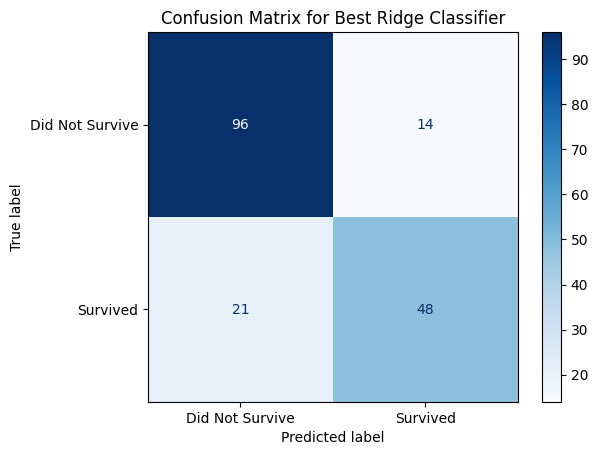

[CV] END .............................estimator__alpha=0.001; total time=   0.1s
[CV] END ...............................estimator__alpha=100; total time=   0.1s
[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ................................estimator__alpha=10; total time=   0.2s
[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ................................estimator__alpha=10; total time=   0.1s
[CV] END ...............................estimator__alpha=100; total time=   0.1s
[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ................................estimator__alpha=10; total time=   0.1s
[CV] END .............................estimator__alpha=0.001; total time=   0.1s
[CV] END ..............................estimator__alpha=0.01; total time=   0.1s
[CV] END ...............................estimator__alpha=100; total time=   0.1s
[CV] END ...................

In [ ]:
y_pred = ridge_search.predict(X_test)

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot it using ConfusionMatrixDisplay
# You can customize the display names if your labels are 0 and 1
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Survive', 'Survived'])

disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Best Ridge Classifier")
plt.show()

In [132]:
create_submission(df_test['PassengerId'], ridge_search.predict(df_test))


Submission file 'input/submission_1761263114.446649.csv' created successfully!


#### SGDClassifier

In [137]:
from sklearn.linear_model import SGDClassifier

In [139]:
def train_sgd_pipeline(preprocessing):
    pipeline = Pipeline(
        steps=[
            ('prep', preprocessing),
            ('estimator', SGDClassifier())
        ]
    )
    param_grid = {
        'estimator__loss': ['log_loss', 'hinge'],
        'estimator__penalty': ['l2', 'l1', 'elasticnet'],
        'estimator__alpha': [0.0001, 0.001, 0.01]
    }
    return GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=-1, 
                        scoring='accuracy',
                        verbose=2)

preprocess = create_preprocess_steps()
sgd_search = train_sgd_pipeline(preprocess)
sgd_search.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'estimator__alpha': [0.0001, 0.001, ...], 'estimator__loss': ['log_loss', 'hinge'], 'estimator__penalty': ['l2', 'l1', ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('age_pipeline', ...), ('embarked_pipeline', ...), ...]"


In [140]:
def show_cv_results(grid_search):
    results_df = pd.DataFrame(grid_search.cv_results_)

    # Select and rename the most important columns for clarity
    summary_df = results_df[[
        'param_estimator__alpha',
        'mean_test_score',
        'std_test_score',
        'rank_test_score'
    ]].rename(columns={
        'param_estimator__alpha': 'Alpha',
        'mean_test_score': 'Mean Accuracy',
        'std_test_score': 'Std Dev',
        'rank_test_score': 'Rank'
    }).sort_values('Rank')

    print("Grid Search Summary:")
    display(summary_df)

In [141]:
show_cv_results(sgd_search)

Grid Search Summary:


,Alpha,Mean Accuracy,Std Dev,Rank
14,0.0100,0.799183,0.011770,1
13,0.0100,0.797813,0.022704,2
10,0.0010,0.792111,0.022724,3
7,0.0010,0.789373,0.029702,4
16,0.0100,0.782281,0.010381,5
1,0.0001,0.779513,0.024026,6
6,0.0010,0.766946,0.034115,7
12,0.0100,0.765508,0.053719,8
8,0.0010,0.752930,0.051885,9
17,0.0100,0.750103,0.056698,10


In [142]:
def run_local_test(best_estimator):
    y_pred = best_estimator.predict(X_test)

    import matplotlib.pyplot as plt
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot it using ConfusionMatrixDisplay
    # You can customize the display names if your labels are 0 and 1
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Did Not Survive', 'Survived'])

    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for Best Estimator")
    plt.show()

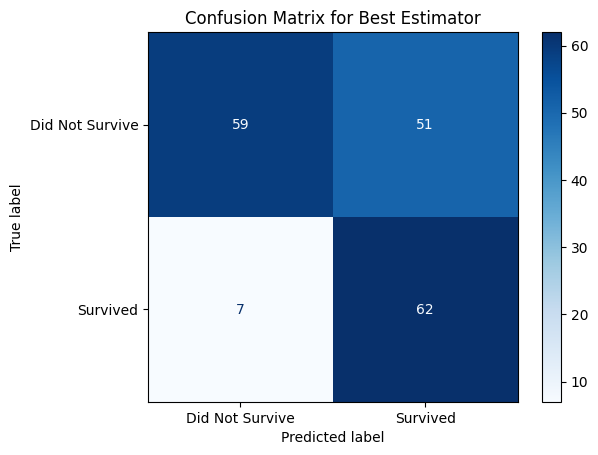

In [143]:
run_local_test(sgd_search.best_estimator_)

In [ ]:
create_submission(df_test['PassengerId'], predictions=sgd_search.predict(df_test))


Submission file 'input/submission_1761264231.414019.csv' created successfully!
[CV] END estimator__alpha=0.0001, estimator__loss=log_loss, estimator__penalty=l1; total time=   0.1s
[CV] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l1; total time=   0.2s
[CV] END estimator__alpha=0.001, estimator__loss=log_loss, estimator__penalty=l1; total time=   0.1s
[CV] END estimator__alpha=0.01, estimator__loss=log_loss, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.01, estimator__loss=hinge, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.0001, estimator__loss=log_loss, estimator__penalty=l1; total time=   0.1s
[CV] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2; total time=   0.2s
[CV] END estimator__alpha=0.001, estimator__loss=log_loss, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.001, estimator__loss=hinge, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__a

[CV] END estimator__alpha=0.0001, estimator__loss=log_loss, estimator__penalty=l1; total time=   0.1s
[CV] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l1; total time=   0.2s
[CV] END estimator__alpha=0.001, estimator__loss=log_loss, estimator__penalty=l1; total time=   0.1s
[CV] END estimator__alpha=0.01, estimator__loss=log_loss, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.01, estimator__loss=hinge, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.0001, estimator__loss=log_loss, estimator__penalty=l1; total time=   0.1s
[CV] END estimator__alpha=0.0001, estimator__loss=hinge, estimator__penalty=l2; total time=   0.2s
[CV] END estimator__alpha=0.001, estimator__loss=log_loss, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.001, estimator__loss=hinge, estimator__penalty=l2; total time=   0.1s
[CV] END estimator__alpha=0.001, estimator__loss=hinge, estimator__penalty=elasticnet; total time=   

#### Decision Tree

In [145]:
from sklearn.tree import DecisionTreeClassifier

In [147]:
def train_dt_pipeline(preprocessing):
    pipeline = Pipeline(
        steps=[
            ('prep', preprocessing),
            ('model', DecisionTreeClassifier())
        ]
    )
    param_grid = {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [3, 4, 5, 6, 7, 8],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4]
    }
    return GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=-1, 
                        scoring='accuracy',
                        verbose=2)

preprocess = create_preprocess_steps()
dt_search = train_dt_pipeline(preprocess)
dt_search.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__criterion': ['gini', 'entropy'], 'model__max_depth': [3, 4, ...], 'model__min_samples_leaf': [1, 2, ...], 'model__min_samples_split': [2, 5, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('age_pipeline', ...), ('embarked_pipeline', ...), ...]"


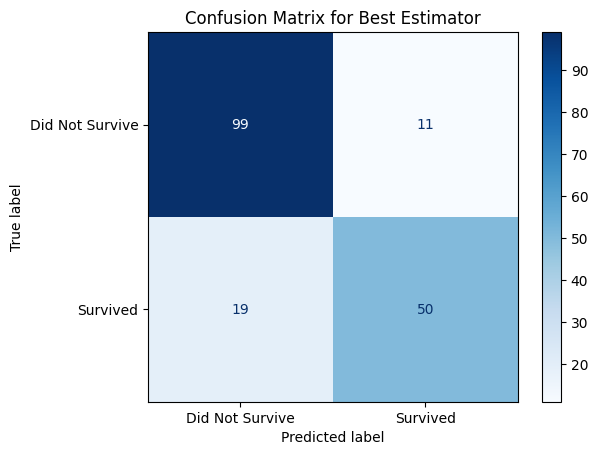

In [149]:
run_local_test(dt_search.best_estimator_)

In [150]:
create_submission(df_test['PassengerId'], predictions=dt_search.predict(df_test))


Submission file 'input/submission_1761278339.750446.csv' created successfully!


#### RandomForestClassifier

In [151]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
def train_rf_pipeline(preprocessing):
    pipeline = Pipeline(
        steps=[
            ('prep', preprocessing),
            ('model', RandomForestClassifier())
        ]
    )
    param_grid = {
        'model__n_estimators': [100, 200, 300],
        'model__max_features': ['sqrt', 'log2'],
        'model__max_depth': [5, 8, 12, 15],
        'model__min_samples_leaf': [1, 2, 4]
    }
    return GridSearchCV(estimator=pipeline,
                        param_grid=param_grid,
                        cv=5,
                        n_jobs=-1, 
                        scoring='accuracy')

preprocess = create_preprocess_steps()
rf_search = train_rf_pipeline(preprocess)
rf_search.fit(X_train, y_train)

,estimator,Pipeline(step...lassifier())])
,param_grid,"{'model__max_depth': [5, 8, ...], 'model__max_features': ['sqrt', 'log2'], 'model__min_samples_leaf': [1, 2, ...], 'model__n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,transformers,"[('age_pipeline', ...), ('embarked_pipeline', ...), ...]"


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=10; total

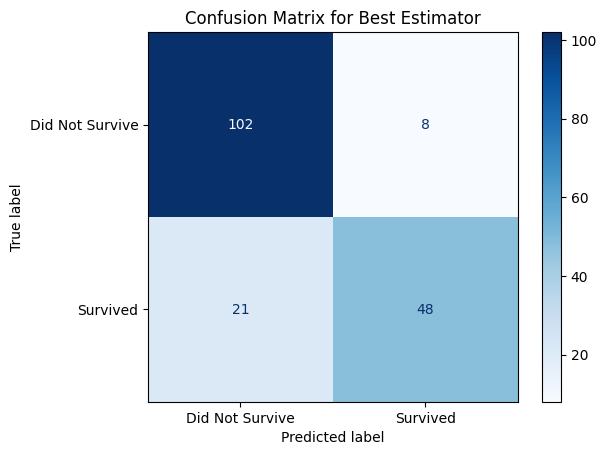

In [155]:
run_local_test(rf_search.best_estimator_)

In [156]:
create_submission(df_test['PassengerId'], predictions=rf_search.predict(df_test))


Submission file 'input/submission_1761279013.652063.csv' created successfully!
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, mo

[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=1, model__min_samples_split=2; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2, model__min_samples_split=5; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=1, model__min_samples_split=5; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=1, model__min_samples_split=10; total time=   0.1s
[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2, model__min_samples_split=5; total t